# RNN stock price predictor

Using Recurrent neural network (RNN) and Long short-term memory (LSTM) algorithm, one of deep learning technique, we'll predict selected ticker's future price. 

Note : This is just a basic code, hence it's not suitable to apply in real life market, and any investment should be your own decision also risk you take.





## Recurrent Neural Network (RNN)

Recurrent neural networks (RNN) are the state of the art algorithm for sequential data and are used by Apple's Siri and and Google's voice search. In RNN, neuron is called cell, information of previously trained cell is used for next cell, hence it is suitable to process sequential data.

[image : RNN]

## Long short-term memory

RNN can store short-term memory, to find correlations of data, it needs long term memory, LSTM is used to support 
this.

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.


## Stock price predictor


### data cleansing

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
# To prevent TF complier error
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Model
import tensorflow as tf
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Bidirectional, Activation
from keras.models import Sequential


    
def get_tickers(ticker):
    data = yf.Ticker(ticker)
    x = data.history(period='max', auto_adjust=True)
#     x = pdr.get_data_yahoo(tickers, start=date_from)
    df = pd.DataFrame(x[['Open', 'High', 'Low', 'Volume', 'Close']])
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.rename(columns={'Close' : 'Close'}, inplace=True)
    return df

def Normalizer(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data, 0) - np.min(data,0)
    return numerator / (denominator + 1e-7)

In [2]:
tickers = 'GME'
df = get_tickers(tickers)
df

,Open,High,Low,Volume,Close
Date,,,,,
2002-02-13,6.480513,6.773399,6.413183,19054000,6.766666
2002-02-14,6.850831,6.864296,6.682506,2755400,6.733003
2002-02-15,6.733001,6.749833,6.632006,2097400,6.699336
2002-02-19,6.665671,6.665671,6.312189,1852600,6.430017
2002-02-20,6.463681,6.648838,6.413183,1723200,6.648838
...,...,...,...,...,...
2021-07-15,160.000000,171.990005,158.009995,4298600,166.820007
2021-07-16,170.149994,179.470001,166.300003,3278800,169.039993
2021-07-19,163.300003,176.000000,161.220001,2436900,173.490005


In [3]:
dfx = Normalizer(df)
dfy = dfx[['Close']]


x = dfx.values.tolist()
y = dfy.values.tolist()

In [4]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4893 entries, 2002-02-13 to 2021-07-21
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4893 non-null   float64
 1   High    4893 non-null   float64
 2   Low     4893 non-null   float64
 3   Volume  4893 non-null   float64
 4   Close   4893 non-null   float64
dtypes: float64(5)
memory usage: 229.4 KB


In [5]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4893 entries, 2002-02-13 to 2021-07-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4893 non-null   float64
dtypes: float64(1)
memory usage: 76.5 KB


In [6]:
data_x = []
data_y = []
window_size = 10
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # not including next day close (i+window_size)
    _y = y[i + window_size] # Next day close
    data_x.append(_x)
    data_y.append(_y)

Run `print(_x, "->", _y)` to see _x values added to data_x and _y

In [7]:
print(_x, "->", _y)

[[0.512879533059172, 0.4055924267117284, 0.6056890169403366, 0.021180367227840263, 0.5453027757404874], [0.470003601315811, 0.3987635086237864, 0.6124021734755716, 0.014168445438673837, 0.5473900090434455], [0.4993034918699731, 0.39992941681900346, 0.6374899691616293, 0.007682164096220611, 0.546955142968733], [0.5007353235273551, 0.4061129237109229, 0.6398084211854268, 0.007972382566799713, 0.5412152735026805], [0.4908184256669295, 0.3874582972816026, 0.6106719806696365, 0.01183655017506972, 0.5145740976290649], [0.4717536492546733, 0.37411277836640455, 0.5624688344409082, 0.0195278470203645, 0.478511398514156], [0.4174229024130799, 0.35248092435062744, 0.5380384676680188, 0.0214802258224421, 0.47619228971901567], [0.4443363529252132, 0.36805418567131326, 0.566725093959146, 0.01630601609697761, 0.48262787412994435], [0.4261731016475972, 0.3608296847810049, 0.5491463287146909, 0.012034426405010018, 0.49552814903227776], [0.4542797519508478, 0.39755595177342135, 0.5879026370073764, 0.015

Past 10 days, given data, latest close is 0.8726370803053053, next day close is 0.8677396475977315

### Prepare train / test dataset

In [8]:
# train dataset
train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

# test dataset
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

### Build model with SimpleRNN

In [9]:
model_rnn = Sequential()

model_rnn.add(SimpleRNN(units = 20, activation='relu',
                   return_sequences=True, input_shape=(window_size, 5)))
model_rnn.add(Dropout(0.1))
model_rnn.add(SimpleRNN(units=40, activation='relu'))
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(units=1))
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 20)            520       
_________________________________________________________________
dropout (Dropout)            (None, 10, 20)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                2440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


### Model fit

In [10]:
model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
history = model_rnn.fit(train_x, train_y, epochs=30, batch_size=30)
pred_y = model_rnn.predict(test_x)

Epoch 1/30
114/114 [==============================] - 27s 6ms/step - loss: 1.9555e-04 - accuracy: 2.3540e-05
Epoch 2/30
114/114 [==============================] - 1s 6ms/step - loss: 5.1302e-05 - accuracy: 0.0013
Epoch 3/30
114/114 [==============================] - 1s 6ms/step - loss: 3.3150e-05 - accuracy: 1.5572e-04
Epoch 4/30
114/114 [==============================] - 1s 6ms/step - loss: 3.4961e-05 - accuracy: 2.9671e-04
Epoch 5/30
114/114 [==============================] - 1s 6ms/step - loss: 3.0402e-05 - accuracy: 5.8190e-05
Epoch 6/30
114/114 [==============================] - 1s 6ms/step - loss: 2.5737e-05 - accuracy: 1.0241e-05
Epoch 7/30
114/114 [==============================] - 1s 6ms/step - loss: 2.6290e-05 - accuracy: 1.9228e-04
Epoch 8/30
114/114 [==============================] - 1s 6ms/step - loss: 2.5359e-05 - accuracy: 2.0728e-04
Epoch 9/30
114/114 [==============================] - 1s 6ms/step - loss: 2.4023e-05 - accuracy: 1.5572e-04
Epoch 10/30
114/114 [==========

### Compare prediction to real

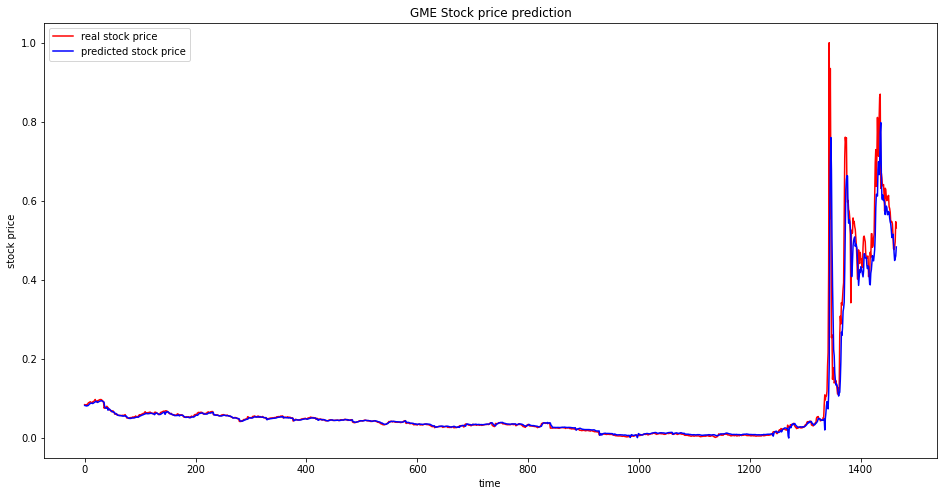

In [11]:
plt.figure(figsize=(16,8))
plt.plot(test_y, c='r', label='real stock price')
plt.plot(pred_y, c='blue', label='predicted stock price')
plt.title(f'{tickers} Stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

### Build model with LSTM

In [12]:
# model = keras.Sequential()
# model.add(layers.LSTM(units=10, activation='relu',
#                       return_sequences=True, input_shape=(window_size, 5)))
# model.add(layers.Dropout(0.1))
# model.add(layers.LSTM(units=10, activation='relu'))
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(units=1))
# model.summary()

model_lstm = Sequential()
model_lstm.add(LSTM(units=64, activation='relu',
                   return_sequences=True, input_shape=(window_size, 5)))
model_lstm.add(LSTM(units=64, activation='relu',
                   return_sequences=False))
model_lstm.add(Dense(units=32))
model_lstm.add(Dense(units=1))
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 53,057
Trainable params: 53,057
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_lstm.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])
history2 = model_lstm.fit(train_x, train_y, epochs=30, batch_size=30)
pred_y2 = model_lstm.predict(test_x)

Epoch 1/30
114/114 [==============================] - 11s 17ms/step - loss: 4.2623e-04 - accuracy: 1.9228e-04
Epoch 2/30
114/114 [==============================] - 2s 19ms/step - loss: 1.0455e-05 - accuracy: 1.5488e-05
Epoch 3/30
114/114 [==============================] - 2s 19ms/step - loss: 9.5429e-06 - accuracy: 4.7413e-04
Epoch 4/30
114/114 [==============================] - 2s 18ms/step - loss: 1.0265e-05 - accuracy: 4.0562e-04
Epoch 5/30
114/114 [==============================] - 2s 19ms/step - loss: 1.0292e-05 - accuracy: 3.4197e-04
Epoch 6/30
114/114 [==============================] - 4s 31ms/step - loss: 1.1312e-05 - accuracy: 2.3413e-04
Epoch 7/30
114/114 [==============================] - 2s 14ms/step - loss: 1.0647e-05 - accuracy: 5.8190e-05
Epoch 8/30
114/114 [==============================] - 2s 13ms/step - loss: 1.0766e-05 - accuracy: 5.8213e-04
Epoch 9/30
114/114 [==============================] - 3s 25ms/step - loss: 8.2608e-06 - accuracy: 6.7541e-05 1s -
Epoch 10/30
1

### Compare prediction to real

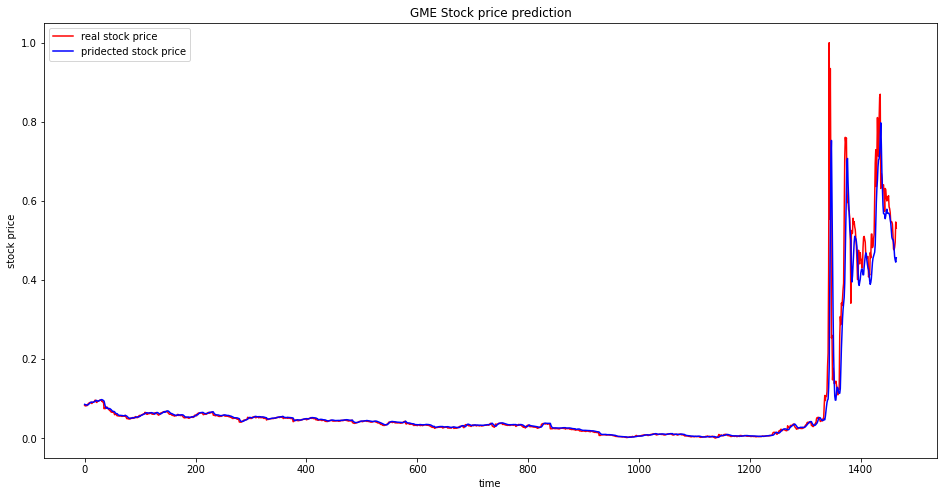

In [14]:
plt.figure(figsize=(16,8))
plt.plot(test_y, c='r', label='real stock price')
plt.plot(pred_y2, c='blue', label='pridected stock price')
plt.title(f'{tickers} Stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

## Evaluating Model

In [15]:
# Losses
history.history['loss'];

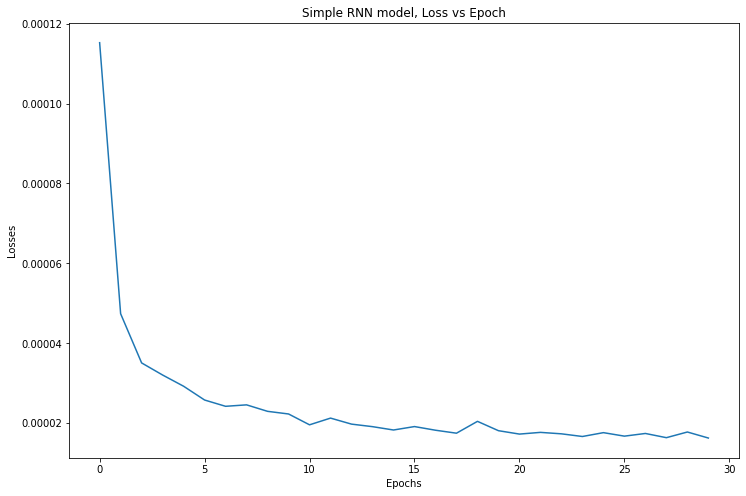

In [16]:
# plot loss vs epochs
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Simple RNN model, Loss vs Epoch')
plt.show()

In [17]:
history2.history['loss'];

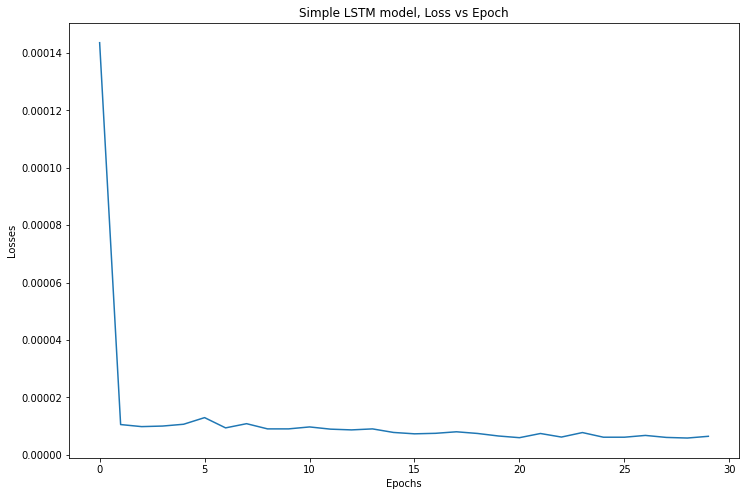

In [18]:
# plot loss vs epochs
plt.figure(figsize=(12,8))
plt.plot(history2.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Simple LSTM model, Loss vs Epoch')
plt.show()

### Predict tomorrw's close price

In [19]:
print(f'RNN predicted {tickers} tomorrow price : {df.Close[-1]*pred_y[-1]/dfy.Close[-1]}')

RNN predicted GME tomorrow price : [168.87404]


In [20]:
print(f'LSTM predicted {tickers} tomorrow price : {df.Close[-1]*pred_y2[-1]/dfy.Close[-1]}')

LSTM predicted GME tomorrow price : [159.64194]
